<a href="https://colab.research.google.com/github/ezekay30/Crime_analysis/blob/master/Crime_Analysis_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install pyspark library**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8bcf3b5d165c50bfd47f486bae3aadc1edba6d03e3030b43607dcb09186712ac
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


**Get dataset from my github account**

In [2]:
!git clone https://github.com/ezekay30/Crime_analysis/

Cloning into 'Crime_analysis'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 54 (delta 7), reused 52 (delta 5), pack-reused 0
Receiving objects: 100% (54/54), 14.08 MiB | 19.60 MiB/s, done.
Resolving deltas: 100% (7/7), done.


**Install libraries for hypothesis testing and data encoding**

In [3]:
!pip install pingouin category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.3 MB/s eta 0:00:00


Importing all necessary libraries

In [4]:
# import libraries
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from pyspark.ml.stat import Correlation
import pingouin as pg
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

## Loading the datasets
- Initiates a spark session using pyspark library
- Takes path of reference and offence dataset into a variable
- uses pandas to load dataset from each file path into `ref`  and `tables`

Libraries used:
1. Pandas
2. pyspark

In [5]:
# Create spark session
spark = SparkSession.builder.master("local[*]").appName('Analysis').getOrCreate()

# File paths
ref_filepath = '/content/Crime_analysis/datasets/reccrime-offence-ref.xlsx'
offence_filepath = '/content/Crime_analysis/datasets/prc-pfa-mar2013-onwards-tables-191023.xlsx'

# Load excel datasets into pandas dataframes
ref = pd.read_excel(ref_filepath)
tables = pd.read_excel(offence_filepath, sheet_name=None)

## Extracts Individual year from `tables`
- uses pandas `to_excel` method to save each selected year as an excel file

In [6]:
# Save sheets in workbook to storage for easier usage
tables['2019-20'].to_excel('2019.xlsx')
tables['2020-21'].to_excel('2020.xlsx')
tables['2021-22'].to_excel('2021.xlsx')
tables['2022-23'].to_excel('2022.xlsx')
tables['2023-24'].to_excel('2023.xlsx')

# ---- follow above format to extract and save more datasets


## Loads extracted data into pandas
- using the pandas `read_excel` method to load each year into pandas dataframe

In [7]:
# Select the table of interest and create a dataframe
yr_2019 = pd.read_excel('./2019.xlsx')
yr_2020 = pd.read_excel('./2020.xlsx')
yr_2021 = pd.read_excel('./2021.xlsx')
yr_2022 = pd.read_excel('./2022.xlsx')
yr_2023 = pd.read_excel('./2023.xlsx')

## Converting pandas dataframe into pypspark dataframe
- Uses pyspark `createDataFrame` method to create pyspark dataframe

- Library used:
1. Pyspark

In [8]:
# Convert each year and reference to pyspark dataframe
reference = spark.createDataFrame(ref)
df_2019 = spark.createDataFrame(yr_2019)
df_2020 = spark.createDataFrame(yr_2020)
df_2021 = spark.createDataFrame(yr_2021)
df_2022 = spark.createDataFrame(yr_2022)
df_2023 = spark.createDataFrame(yr_2023)

## Creates a temporary view of extracted years in order to use sql queries
- uses `createOrReplaceTempView` to create temporary table, as it is a requirement to use sql queries in pyspark

- Sql query to join append each successive year using `UNION` with no duplicates

- Load the sql in pyspark to get back dataframe

- Library used:
  1. pyspark
  2. sql

In [9]:
# Create temporary views( AKA TABLES) of the dataframes
df_2019.createOrReplaceTempView('df_2019')
df_2020.createOrReplaceTempView('df_2020')
df_2021.createOrReplaceTempView('df_2021')
df_2022.createOrReplaceTempView('df_2022')
df_2023.createOrReplaceTempView('df_2023')

# Write sql queries to join tables
query_1 = """
                SELECT * FROM df_2019
                UNION
                SELECT * FROM df_2020
                UNION
                SELECT * FROM df_2021
                UNION
                SELECT * FROM df_2022
                UNION
                SELECT * FROM df_2023
"""

# Load query and return dataframe
offence_df = spark.sql(query_1)

## Renaming columns to remove white spaces
- A dictionary is created with old name and new names
- A loop is created to items in dictionary created
- For each iterations, the column name is changed using `withColumnRenamed` method from pyspark

- Library used:
  1. pyspark

In [10]:
# Rename col to remove white space
rename_cols = {
                'Financial Year': 'Financial_Year',
                'Financial Quarter':'Financial_Quarter',
                'Force Name':'Force_Name',
                'Offence Description':'Offence_Description',
                'Offence Group':'Offence_Group',
                'Offence Subgroup':'Offence_Subgroup',
                'Offence Code':'Offence_Code',
                'Number of Offences':'Number_of_Offences',
                'Old PRC offence group': 'Old_PRC_offence_group',
                'Old offence sub-group': 'Old_offence_sub-group',
                'New ONS offence group': 'New_ONS_offence_group',
                'New ONS sub-offence group': 'New_ONS_sub_offence_group'
}

# Loops through rename_cols and removes white space
for old_name, new_name in rename_cols.items():
    offence_df = offence_df.withColumnRenamed(old_name, new_name)
    reference = reference.withColumnRenamed(old_name, new_name)


## Data Cleaning #1

- Removes all duplicates in reference
- Create a temporary table for sql queries
- Sql queries written using `INNER JOIN` to return all values present in both tables

Library used:
  1. pyspark
  2. sql

In [11]:
# Drop duplicates in offence_ref
reference = reference.dropDuplicates()

# Create temporary views of the dataframes
offence_df.createOrReplaceTempView('offence_df')
reference.createOrReplaceTempView('reference')

# Write sql query to join tables
query_2 = """
                    SELECT
                    offence_df.*,
                    reference.New_ONS_offence_group,
                    reference.New_ONS_sub_offence_group
                    FROM offence_df
                    INNER JOIN reference
                    ON offence_df.Offence_Code = reference.Offence_Code;
                """

#  Create offence_final with query
offence_skewed = spark.sql(query_2)

## Pyspark Schema

In [12]:
# Print schema
offence_skewed.printSchema()

root
 |-- Unnamed: 0: long (nullable = true)
 |-- Financial_Year: string (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- New_ONS_offence_group: string (nullable = true)
 |-- New_ONS_sub_offence_group: string (nullable = true)



## Data Cleaning #2
- Drop `Unnamed: 0` column using `drop` method from pyspark

Library used:
  1. pyspark

In [13]:
offence_skewed = offence_skewed.drop('Unnamed: 0')

## Print first 3 Rows
- to check for changes

In [14]:
# Show first 3 rows
offence_skewed.show(3)

+--------------+-----------------+------------------+--------------------+---------------+--------------------+------------+------------------+---------------------+-------------------------+
|Financial_Year|Financial_Quarter|        Force_Name| Offence_Description|  Offence_Group|    Offence_Subgroup|Offence_Code|Number_of_Offences|New_ONS_offence_group|New_ONS_sub_offence_group|
+--------------+-----------------+------------------+--------------------+---------------+--------------------+------------+------------------+---------------------+-------------------------+
|       2019/20|                1|            Dorset|Sexual assault on...|Sexual offences|Other sexual offe...|         17A|                25|      Sexual offences|     Other sexual offe...|
|       2019/20|                1|    Cambridgeshire|Sexual assault on...|Sexual offences|Other sexual offe...|         17A|                26|      Sexual offences|     Other sexual offe...|
|       2019/20|                1|Greate

## Data Cleaning #3
- using `withColumn` and `substring`, we extract the first 4 characters from the financial year column

- using the `cast` method, we change the data type of financial year to integers

Library used:
  1. pyspark

In [15]:
# Get year from financial year column
offence_skewed = offence_skewed.withColumn('Financial_Year',
                                         substring('Financial_Year',  1,  4))

# Convert Financial year column to int
offence_skewed = offence_skewed.withColumn('Financial_Year',
                                  offence_skewed.Financial_Year.cast('int'))

## Print Schema
- to check changes in data type of `Financial_Year`

In [16]:
# Check to confirm change in data type
offence_skewed.printSchema()

root
 |-- Financial_Year: integer (nullable = true)
 |-- Financial_Quarter: long (nullable = true)
 |-- Force_Name: string (nullable = true)
 |-- Offence_Description: string (nullable = true)
 |-- Offence_Group: string (nullable = true)
 |-- Offence_Subgroup: string (nullable = true)
 |-- Offence_Code: string (nullable = true)
 |-- Number_of_Offences: long (nullable = true)
 |-- New_ONS_offence_group: string (nullable = true)
 |-- New_ONS_sub_offence_group: string (nullable = true)



## Summary Statisitics
- Finds the total number of offences using the aggregate method `agg` and `collect`.

In [17]:
# Total num of offences
totalsum = offence_skewed.agg(sum('Number_of_Offences')).collect()[0][0]
display(f'The total sum of Number of offences from 2019-2023 is: {totalsum}')

'The total sum of Number of offences from 2019-2023 is: 18978512'

## Descriptive Statisitics
- The standard deviation `884.6` being 4 times the mean `218.7` suggests that the data is highly skewed.
- we also note that the max is `29480` which is too high to be a valid entry
- This was found using the `describe` method

- Library used:
    1. Pyspark

In [18]:
# Descriptive statistics of  Numeric Column
offence_skewed.describe(['Number_of_Offences']).show()

+-------+------------------+
|summary|Number_of_Offences|
+-------+------------------+
|  count|             86768|
|   mean|218.72708832749402|
| stddev|  884.620296000273|
|    min|                 0|
|    max|             29480|
+-------+------------------+



## Handling skewed Data using percentile
- Using approxQuantile, we get the 5th and 95th percentile values
- Using sql queries, we will only return values within the 5th and 95th percentile

In [19]:
# Gets the value for the 5th, 50th and 95th percentile
offence_skewed.approxQuantile("Number_of_Offences", [0.05, 0.5, 0.95], relativeError=0.01)

[0.0, 11.0, 970.0]

In [20]:
# Print number of rows in offence skewed before handling skew
display(f'The count of offence_skewed is: {offence_skewed.count()}')

'The count of offence_skewed is: 86768'

- Use sql `WHERE` statment to filter for values between the 5th and 95th percentile
- Convert the result back into pyspark dataframe

- Library used:
    1. pyspark
    2. sql

In [21]:
# Create temporary view
offence_skewed.createOrReplaceTempView('offence_skewed')

# sql queries
query_3 = """
        SELECT
         *
        FROM offence_skewed
        WHERE Number_of_Offences >= 0 AND Number_of_Offences <= 970
"""
# load query and get dataframe
offence_final = spark.sql(query_3)

In [22]:
# Print number of rows in offence final after handling skew

display(f'The count of offence_final is: {offence_final.count()}')

'The count of offence_final is: 81956'

## Total Sum of NUM of Offences
- find the total sum of offences after handling skew

In [23]:
# Total num of offences
totalsum = offence_final.agg(sum('Number_of_Offences')).collect()[0][0]
display(f'The total sum of Number of offences from 2019-2023 is: {totalsum}')

'The total sum of Number of offences from 2019-2023 is: 6124199'

## Descriptive Statisitics #2
- The standard deviation `157.4` with a mean of `74.7`
- This was found using the `describe` method

- Library used:
    1. Pyspark

In [24]:
# Descriptive statistics of  Numeric Column
offence_final.describe(['Number_of_Offences']).show()

+-------+------------------+
|summary|Number_of_Offences|
+-------+------------------+
|  count|             81956|
|   mean| 74.72545024159305|
| stddev|157.39049677424788|
|    min|                 0|
|    max|               970|
+-------+------------------+



### Summary statistics questions:
- What are the Top Crime Per Force for each year?
- What is the total number of offences for each force between 2019 and 2023?
- Which force has the highest total number of offence?

In [25]:
df_stat = offence_final.toPandas()

- Which force has the highest total number of offence?
    - **Greater Manchester** : **243160**

In [26]:
force = (df_stat
         .groupby('Force_Name')
         .agg({'Number_of_Offences': 'sum'})
         .sort_values(by='Number_of_Offences', ascending=False)
         .head(5))
force.rename(columns={'Number_of_Offences': 'Total_Number_of_Offences'})

,Total_Number_of_Offences
Force_Name,
Greater Manchester,243160
West Yorkshire,229302
Metropolitan Police,219318
West Midlands,210589
Hampshire,179166


- What is the total number of offences for each force between 2019 and 2023?
    - results displayed in table below

In [27]:
force_b = (df_stat
           .groupby('Force_Name')
           .agg({'Number_of_Offences': 'sum'})
           .sort_values(by='Number_of_Offences', ascending=False)
           .rename(columns={'Number_of_Offences': 'Total_Num_of_Offences'}))
force_b.head(10)

,Total_Num_of_Offences
Force_Name,
Greater Manchester,243160
West Yorkshire,229302
Metropolitan Police,219318
West Midlands,210589
Hampshire,179166
Thames Valley,178562
Kent,177751
Sussex,170875
Essex,167912


- What are the Top Crime Per Force for each year?
    - Top crime based on total number of offences commited was gotten and they are as follows:
      1. Theft offences
      1. Criminal damage and arson
      1. Violence against the person
      1. Sexual offences
      1. Drug offences
      1. Public order offences
      1. Miscellaneous crimes against society
      1. Possession of weapons offence
      1. Robbery

In [28]:
crime = (df_stat
         .groupby('New_ONS_offence_group')
         .agg({'Number_of_Offences': 'sum'})
         .rename(columns={'Number_of_Offences': 'Total_Number_of_Offences'})
         .sort_values(by='Total_Number_of_Offences',
                      ascending=False))

crime = crime.rename_axis('Top Crime', axis=0)

crime

,Total_Number_of_Offences
Top Crime,
Theft offences,1678306
Criminal damage and arson,1114887
Violence against the person,800080
Sexual offences,689508
Drug offences,509913
Public order offences,509269
Miscellaneous crimes against society,465087
Possession of weapons offences,208021
Robbery,149128


### Implementing MapReduce:
- MapReduce was used to answer the following quesions:
  - Top 10 crimes from 2019-2023
  - Top Crime in 2020

- The map method was used to map each entry for offence group and number of offences in to key: value pairs
- The reduceByKey method was used to to count each occurence into values for the keys, each representing the offence group and number of offences
- The entries were sorted in ascending order using the sortBy method
- Top values were selected

In [29]:
# Convert pyspark data in a rdd
offence_rdd = offence_final.rdd

# Map phase: Create key-value pairs (crimetype, number_of_offences)
mapped_rdd = offence_rdd.map(lambda row: (row['New_ONS_offence_group'],
                                          row['Number_of_Offences']))

# Reduce phase: Aggregate offences by New_ONS_offence_group
reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: x + y)

# Sort by number of offences in descending order
sorted_rdd = reduced_rdd.sortBy(lambda x: x[1], ascending=False)

# Selects the top Entries
top_10_crimes = sorted_rdd.take(10)

# Print the results
print('Top 10 Crime for 2019-2023')
print('--------------------------------')
for crime, total_offences in top_10_crimes:
    print(f"Crime: {crime}, Total Offences: {total_offences}")

Top 10 Crime for 2019-2023
--------------------------------
Crime: Theft offences, Total Offences: 1678306
Crime: Criminal damage and arson, Total Offences: 1114887
Crime: Violence against the person, Total Offences: 800080
Crime: Sexual offences, Total Offences: 689508
Crime: Drug offences, Total Offences: 509913
Crime: Public order offences, Total Offences: 509269
Crime: Miscellaneous crimes against society, Total Offences: 465087
Crime: Possession of weapons offences, Total Offences: 208021
Crime: Robbery, Total Offences: 149128


##### Summary
- A temporary table was created
- Sql was used to get only data for year 2020
- Pyspark dataframe was converted to rdd, inorder to use MapReduce
- The map method was used to map each entry for offence group and number of offences in to key: value pairs
- The reduceByKey method was used to to count each occurence into values for the keys, each representing the offence group and number of offences
- The entries were sorted in ascending order using the sortBy method
- Top first entry was selected

In [30]:
# Create a temporary view to subset for the year 2020
offence_final.createOrReplaceTempView('offence_rdd')

# Sql query to get data from Only year 2020
query_rdd = """
        SELECT
            Financial_Year,
            New_ONS_offence_group,
            Number_of_Offences
        FROM
            offence_rdd
        WHERE Financial_Year == '2020'
"""
# Gets back pyspark dataframe
offence_2020_rdd = spark.sql(query_rdd)

# Convert pyspark to rdd
offence_2020_rdd = offence_2020_rdd.rdd

# Map phase: Create key-value pairs (crimetype, number_of_offences)
mapped_2020_rdd = offence_2020_rdd.map(lambda row: (row['New_ONS_offence_group'],
                                          row['Number_of_Offences']))

# Reduce phase: Aggregate offences by New_ONS_offence_group
reduced_2020_rdd = mapped_2020_rdd.reduceByKey(lambda x, y: x + y)

# Sort by number of offences in descending order
sorted_2020_rdd = reduced_2020_rdd.sortBy(lambda x: x[1], ascending=False)

# Selects the top Entries
top_10_crimes = sorted_2020_rdd.take(1)

# Print the results
print('Top 10 Crime for 2020')
print('--------------------------------')
for crime, total_offences in top_10_crimes:
    print(f"Crime: {crime}, Total Offences: {total_offences}")

Top 10 Crime for 2020
--------------------------------
Crime: Theft offences, Total Offences: 386689


## Correlation and Covariance
- Using `cov` and `corr` method to find the correlation and covariance of Financial_Year, Financial_Quarter and Number_of_Offences

In [31]:
# Correlation betwen financial year and number of offences
yr_corr_offence = offence_final.corr('Financial_Year', 'Number_of_Offences')

# Correlation betwen financial Quarter and number of offences
qt_corr_offence = offence_final.corr('Financial_Quarter', 'Number_of_Offences')

# Covariance betwen financial year and number of offences
yrx_corr_offence = offence_final.cov('Financial_Year', 'Number_of_Offences')

# Covariance betwen financial Quarter and number of offences
qtx_corr_offence = offence_final.cov('Financial_Quarter', 'Number_of_Offences')


print(f'The correlation between Financial Quarter and Number of offences is: {qt_corr_offence:.4f}')
print(f'The correlation between Financial Year and Number of offences is: {yr_corr_offence:.4f}')
print(f'The covariance between Financial Year and Number of offences is: {yrx_corr_offence:.4f}')
print(f'The covariance between Financial Quarter and Number of offences is: {qtx_corr_offence:.4f}')

The correlation between Financial Quarter and Number of offences is: -0.0025
The correlation between Financial Year and Number of offences is: 0.0083
The covariance between Financial Year and Number of offences is: 1.6067
The covariance between Financial Quarter and Number of offences is: -0.4477


## Comparision of Degree of Skewness
- skewness was found for `offence_final` and `offence_skewed`, and we see that the degree of skewness has drastically reduced
- This was done using `skewness` method

In [32]:
# check for skewness of Number of Offences
skewness_num_of_offences = offence_final.select(skewness('Number_of_Offences')).collect()[0][0]
skewness_num_of_offences_sk = offence_skewed.select(skewness('Number_of_Offences')).collect()[0][0]

print(f'The Degree of skewness in offence_final is: {skewness_num_of_offences: .2f}')
print(f'The Degree of skewness in offence_skewed is: {skewness_num_of_offences_sk: .2f}')

The Degree of skewness in offence_final is:  3.15
The Degree of skewness in offence_skewed is:  12.29


## Hypothesis Testing

#### Research questions

 -  Has the overall number of offenses changed significantly over time?
    *   Null hypothesis (H0): The mean number of offenses has not changed significantly over time.
    *    Alternate hypothesis (Ha): The mean number of offenses has changed significantly over time.
    *  Test: ANOVA


---


 -  Do certain financial quarters exhibit consistently higher or lower offense rates?
    *  H0: There is no significant difference in offense rates between financial quarters.
    *  Ha: There is a significant difference in offense rates between financial quarters.
    * Test: ANOVA comparing offense rates across quarters.


---


 -  Does the type of offense tend to change based on the financial quarter?
    * H0: There is no association between offense type and financial quarter.
    * Ha: There is an association between offense type and financial quarter.
    * Test: Chi-square test of independence.
---

-  Are certain offense groups or subgroups more likely to occur in specific police force jurisdictions?
    * H0: The distribution of offense groups is the same across different police force jurisdictions.
    * Ha: The distribution of offense groups is different across different police force jurisdictions.
    * Test: Chi-square test of independence.
---

    NOTE:Let our signifiance level (alpha)  be 0.1

## Sample Data
- takes a sample of 50% from offence_final and converts it to pandas for hypothesis testing
- using `select`, `sample`, `toPandas` which selects column of interest, takes a specified sample and converts to pandas respectively



In [33]:
 # Does the type of offense tend to change based on the financial quarter?
sample_offence = offence_final.select('Financial_Year', 'Financial_Quarter',
                      'Force_Name',
                      'New_ONS_offence_group',
                      'Number_of_Offences').sample(False, 0.50, 42).toPandas()

### Hypothesis 1
- Has the overall number of offenses changed significantly over time?
  - Null hypothesis (H0): The mean number of offenses has not changed significantly over time.
  - Alternate hypothesis (Ha): The mean number of offenses has changed significantly over time.
  - Test: ANOVA(analysis of variance)

- Result:
  - Our pvalue `0.416748` is greater than our significane level `0.1`, we fail to reject the null hypothesis
  - Therefore, There is no significant change over time in the mean number of offences

- Performed using:
    - anova: a method from the pingouin package

In [34]:
# ANOVA TESTING
val = pg.anova(data=sample_offence,
         dv='Number_of_Offences',
         between='Financial_Year')

# Displays outputs
display(val)

,Source,ddof1,ddof2,F,p-unc,np2
0,Financial_Year,4,41055,0.980372,0.416748,0.000096


### Hypothesis_2
 -  Do certain financial quarters exhibit consistently higher or lower offense rates?
    *  H0: There is no significant difference in offense rates between financial quarters.
    *  Ha: There is a significant difference in offense rates between financial quarters.
    * Test: ANOVA comparing offense rates across quarters.


- Result:
  - Our pvalue `0.946519` is greater than our significane level `0.1`, we fail to reject the null hypothesis

  - Therefore, There is no significant change over quarters in the mean number of offences

- Performed using:
  - anova: a method from the pingouin package




In [35]:
# ANOVA TESTING
val_1 = pg.anova(data=sample_offence,
         dv='Number_of_Offences',
         between='Financial_Quarter')

# Display outputs

display(val_1)

,Source,ddof1,ddof2,F,p-unc,np2
0,Financial_Quarter,3,41056,0.123082,0.946519,0.000009


### Hypothesis_3
  -  Does the type of offense tend to change based on the financial quarter?
    * H0: There is no association between offense type and financial quarter.
    * Ha: There is an association between offense type and financial quarter.
    * Test: Chi-square test of independence.

- Result:
  - Our pvalue `0.991481` is greater than our significane level 0.1, we fail to reject the null hypothesis

  - Therefore, There is no association between offense type and financial quarter

- Performed using:
  - chi2_independence: a method from the pingouin package


In [36]:
#  Perfrom chisquare_test of independence
expected, observed, stats = pg.chi2_independence(data=sample_offence,
                                                 x='New_ONS_offence_group',
                                                 y='Financial_Quarter')

# Displays output
display(stats.iloc[0:1, :])

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,10.61897,24.0,0.991481,0.009285,0.132144


### Hypothesis_4

-  Are certain offense groups or subgroups more likely to occur in specific police force jurisdictions?
    * H0: The distribution of offense groups is the same across different police force jurisdictions.
    * Ha: The distribution of offense groups is different across different police force jurisdictions.
    * Test: Chi-square test of independence.

- Result:
  - Our pvalue `0.723937` is greater than our significane level 0.1, we fail to reject the null hypothesis

  - Therefore, he distribution of offense groups is the same across different police force jurisdictions

- Performed using:
  - chi2_independence: a method from the pingouin package

In [37]:
#  Perfrom chisquare_test of independence
expected, observed, stats = pg.chi2_independence(data=sample_offence,
                                                 x='New_ONS_offence_group',
                                                 y='Force_Name')

# Displays output
display(stats.iloc[0:1, :])

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,327.9903,344.0,0.723937,0.031599,0.44586


## Data Visualization

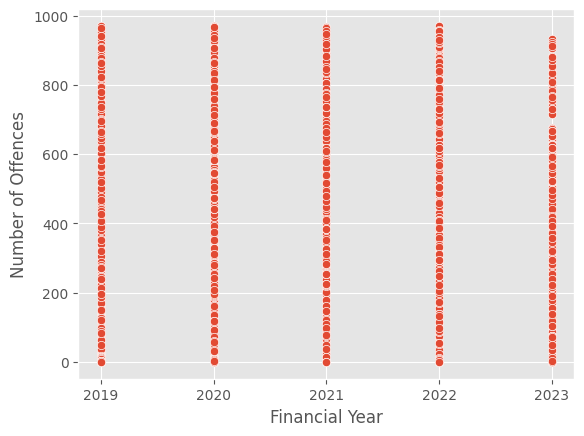

In [38]:
# Sample target columns from dataframe
sct = offence_final.select('Financial_Year', 'Number_of_Offences').sample(False, 0.50, 42).toPandas()

# Scatter plot to check for relationship between Financial year and Number of Offences
sns.scatterplot(data=sct, x='Financial_Year',
                y='Number_of_Offences').set(xlabel='Financial Year',
                                            ylabel='Number of Offences',
                                  xticks=[2019, 2020, 2021, 2022, 2023])

# Show plot
plt.show()

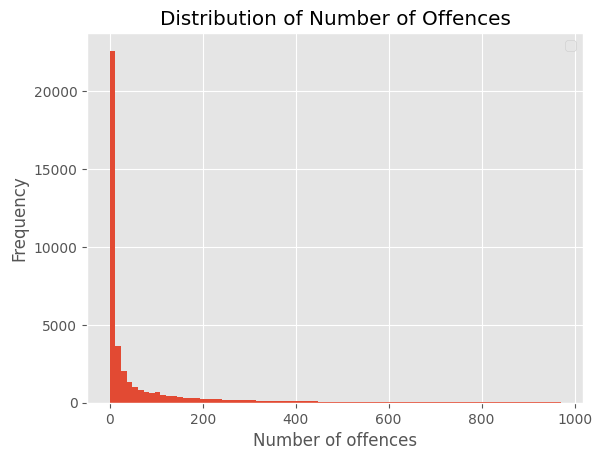

In [39]:
# Gets sample from target column and converts to pandas
num_off_hst = offence_final.select('Number_of_Offences').sample(False,
                                                                0.50,
                                                                42).toPandas()
# Plot Distribution
num_off_hst.plot(kind='hist', bins=80)
plt.title('Distribution of Number of Offences')
plt.legend('')
plt.xlabel('Number of offences');

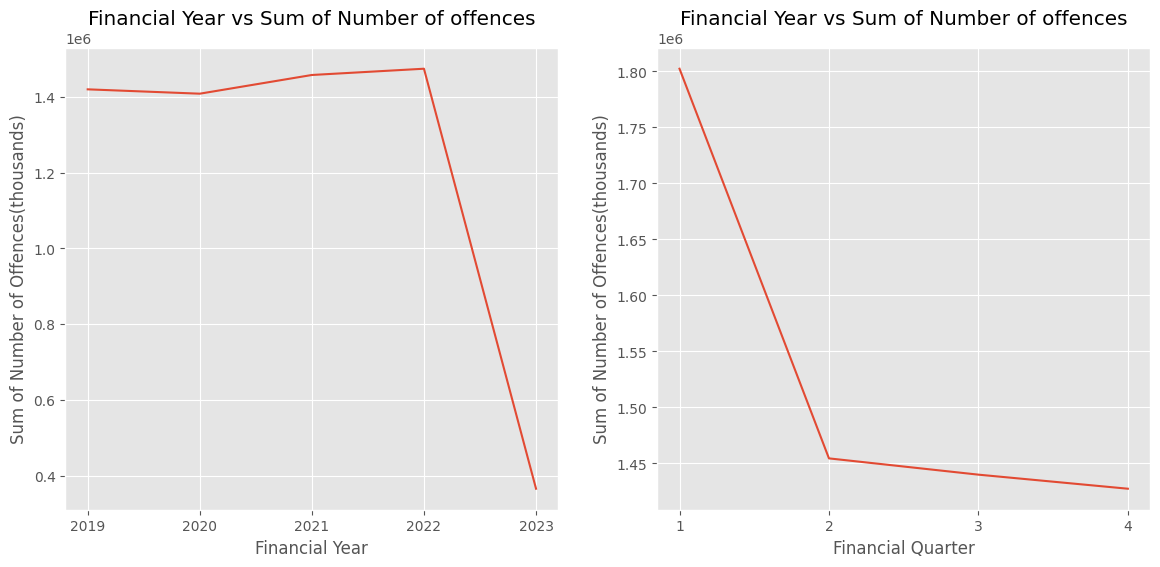

In [40]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Group data by financial year and find the sum of each year
trends_1 = offence_final.groupBy('Financial_Year').sum('Number_of_Offences').toPandas()

# Group data by financial quarter and find the sum of each offences
trends_2 = offence_final.groupBy('Financial_Quarter').sum('Number_of_Offences').toPandas()

# Plot Trends_1
sns.lineplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',
                    ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
                    xlabel='Financial Year',
                    ylabel='Sum of Number of Offences(thousands)',
                    xticks=[2019, 2020, 2021, 2022, 2023])
# Plot  Trends_2
sns.lineplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',
                    ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
                    xlabel='Financial Quarter',
                    ylabel='Sum of Number of Offences(thousands)',
                    xticks=[1, 2, 3, 4],)
# Show plot
plt.show()

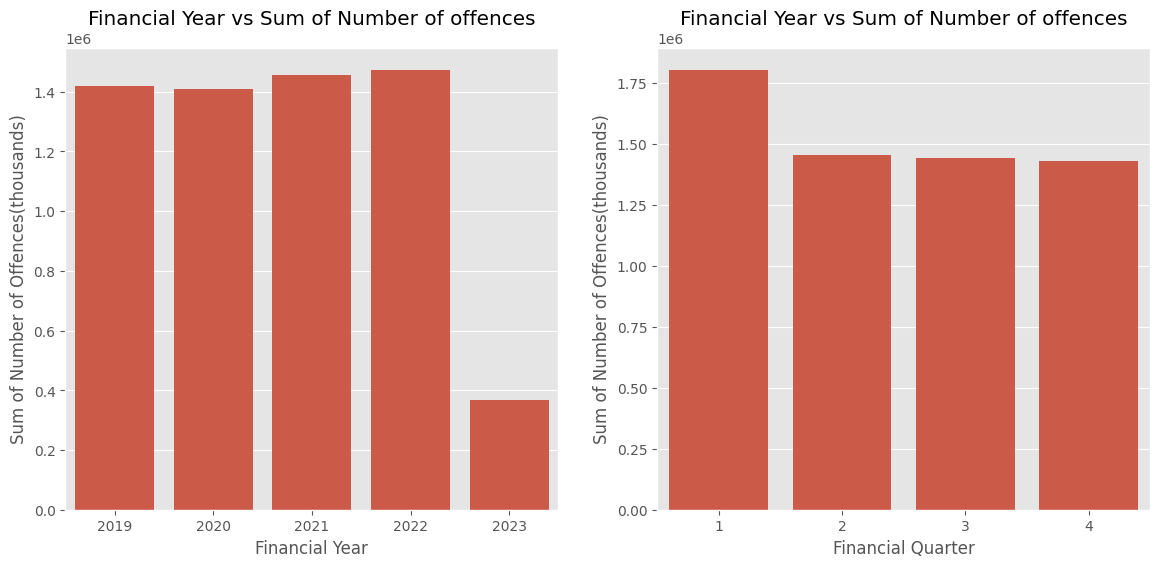

In [41]:
# Set the figure size for plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Barplot of Financial year vs number of offences
sns.barplot(data=trends_1,  x='Financial_Year', y='sum(Number_of_Offences)',
            ax=ax[0]).set(title='Financial Year vs Sum of Number of offences',
            xlabel='Financial Year',
            ylabel='Sum of Number of Offences(thousands)')

# Plot Barplot of Financial quarter vs number of offences
sns.barplot(data=trends_2,  x='Financial_Quarter', y='sum(Number_of_Offences)',
              ax=ax[1]).set(title='Financial Year vs Sum of Number of offences',
              xlabel='Financial Quarter',
              ylabel='Sum of Number of Offences(thousands)')

# Show plot
plt.show()

## Machine Learning

### **Model Modeling**
- Offense Classification:
    - Can we accurately classify offenses into different groups based on their characteristics?

- The Machine Algorithm used was Decision Tree classifier as it can be used to make multiclass predictions

### CLASSIFICATION
- Task done
  - get features for X and y
  - encode values in y to numeric, due to some ml algorithm being unable to work with categorical data
  - Apply the encoding to y using `replace`, it replaces all values with values in the encoder
  - Using `OrdinalEncoder` to encode values in X_b into numeric
  - Fit and transform X_b into new variable `X_b_ord`
  - Append both X_a and X_b to from X.
  - Split X, y into train/test
  - Fit training sample into DecisionTree classifer
  - Make predictions using `tree`
  - Evaluate the accuracy of `tree`

In [42]:
# Features variable X_a and _X_b
X_a = offence_final.select('Financial_Year', 'Financial_Quarter',
                           'Number_of_Offences' ).toPandas()
X_b = offence_final.select('Offence_Code','Force_Name' ).toPandas()
# target variable
y = offence_final.select('New_ONS_offence_group').toPandas()

In [43]:
# Label encoding for Y
encoder = {
    'Sexual offences': 0,
    'Miscellaneous crimes against society': 1,
    'Violence against the person':  2,
    'Criminal damage and arson': 3,
    'Theft offences': 4,
    'Possession of weapons offences':5,
    'Drug offences': 6,
    'Robbery': 7,
    'Public order offences': 8
}

# Encode values into y
y = y.replace(encoder)

In [44]:
# Initialize one hot encoder
ord = OrdinalEncoder()
X_b_ord = ord.fit_transform(X_b)

# Features vairable
X = pd.concat([X_a, X_b_ord], axis=1)

In [45]:
# Split into train/test samples
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

In [46]:
# Create Instance
tree = DecisionTreeClassifier(max_depth=12, random_state=42)

# Fit to training data
tree.fit(X_train, y_train)

# Evaluate model
y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'The model made using Decision Tree Classifier has an accuracy of : {accuracy*100}%')

The model made using Decision Tree Classifier has an accuracy of : 84.58394338701805%


##### Model Performance (Decision Tree)
- Models accuracy on training and test data show that our model is able to generalize well and that the model is not overfitting or underfitting.

In [47]:
# Further evalaution to check for overfitting
y_train_pred = tree.predict(X_train)
accuracy_sc = accuracy_score(y_train, y_train_pred)

print(f'The model made using Decision Tree Classifier has an accuracy of : {accuracy_sc*100}%')

The model made using Decision Tree Classifier has an accuracy of : 84.66231468488805%


### LINEAR REGRESSION

- Task done:
  - using `toPandas` method to convert offence_final to pandas dataframe
  - select target feature `Number_of_Offences`
  - Initiate Ordinal Encoder to convert all categorical values in columns to 0s and 1s.
  - Split X, y into train/test data
  - Initialize LinearRegression
  - Fit and train model using training data
  - Make predictions using model
  - Evaluate model performance

In [48]:
# Creates pandas dataframe
reg_df = offence_final.toPandas()

In [49]:
# Subsets for target in reg_df
target = 'Number_of_Offences'
y = reg_df[target]

In [50]:
# Initiate OneHot Encoder
ohe = OneHotEncoder(use_cat_names=True)
X = ohe.fit_transform(reg_df.drop(columns=target))

In [51]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [52]:
# Initialize LinearReg model
lr = LinearRegression(fit_intercept=True, n_jobs=4)

In [53]:
# Fit the model for training
lr.fit(X_train, y_train)

LinearRegression(n_jobs=4)

In [54]:
# Make Prediction based on model
y_pred = lr.predict(X_test)
y_pred

array([  0.6875  ,   7.671875, -14.03125 , ..., 297.6875  , -38.21875 ,
       -28.78125 ])

In [55]:
# Evaluate accuracy of our model
lr.score(X_test, y_test)

0.7114966053824343

In [56]:
# USE MSE to evaluate model
MSE = mean_squared_error(y_test, y_pred)
display(f'Mean Squared Error: {np.round(MSE)}')

'Mean Squared Error: 7379.0'

In [57]:
# Use RMSE to evaluate model
RMSE = mean_squared_error(y_test, y_pred, squared=False)
display(f'Root Mean Squared Error: {np.round(RMSE)}')

'Root Mean Squared Error: 86.0'

In [58]:
# Use MAE to evaluate model
MAE = mean_absolute_error(y_test, y_pred)
display(f'Mean Absolute Error: {np.round(MAE)}')

'Mean Absolute Error: 48.0'

##### Model Performance (Linear Regression)
- Model's predicted values have a strong relationship with actual values, this shows that our model is performing well.

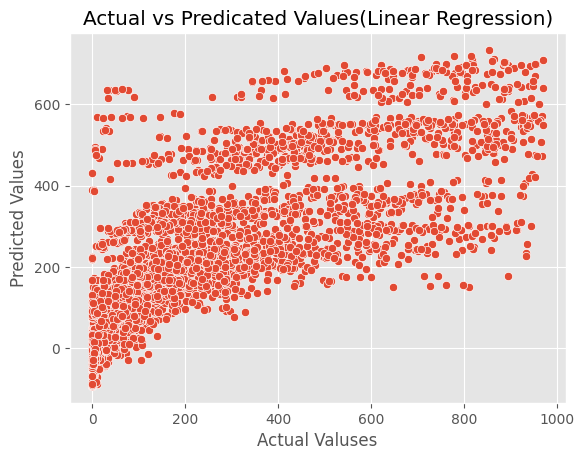

In [59]:
# Vizualizing Actual vs predicted values
sns.scatterplot(x=y_test, y=y_pred,).set(xlabel='Actual Valuses',
                                              ylabel='Predicted Values',
                                              title='Actual vs Predicated Values(Linear Regression)')
plt.show();

##### Deployment of Models
- Models are pickled and saved, and are also made ready for deployment

In [60]:
# save model
import pickle
with open('model_tree.pkl', 'wb') as file:
    pickle.dump(tree, file)

In [61]:
# save model
import pickle
with open('model_lr.pkl', 'wb') as file:
    pickle.dump(lr, file)

## Making  Use of our Model
- using the classifier to classify which crime group some offences belong in
- using the regressor to estimate the number of offences for different quarters of year 2024, 2025, 2026

### Json
- contains future sample data to make predictions using the linear regressor model

In [62]:
# contains data for making future predictions
pred_json = {"Financial_Year":{"0":2024,"1":2024,"2":2024,"3":2024,"4":2024,"5":2025,"6":2025,"7":2025,"8":2025,"9":2026,"10":2026,"11":2026,"12":2026,"13":2026,"14":2026},"Financial_Quarter":{"0":1,"1":3,"2":2,"3":4,"4":2,"5":4,"6":3,"7":2,"8":4,"9":3,"10":2,"11":3,"12":1,"13":1,"14":2},"Force_Name":{"0":"South Yorkshire","1":"Northumbria","2":"Surrey","3":"Hertfordshire","4":"London, City of","5":"West Mercia","6":"Hampshire","7":"Northumbria","8":"Wiltshire","9":"Norfolk","10":"Northamptonshire","11":"Bedfordshire","12":"West Midlands","13":"Metropolitan Police","14":"Warwickshire"},"Offence_Description":{"0":"Arson endangering life","1":"Conspiracy to murder","2":"Disclosure, obstruction, false or misleading statements etc","3":"Conspiracy to murder","4":"Public fear, alarm or distress","5":"Abuse of position of trust of a sexual nature","6":"Perverting the course of justice","7":"Racially or religiously aggravated assault without injury","8":"Possession of controlled drugs (Cannabis)","9":"Forgery or use of false drug prescription","10":"Causing death or serious injury by dangerous driving","11":"Forgery or use of false drug prescription","12":"Other miscellaneous sexual offences","13":"Sexual activity involving child under 16","14":"Burglary in a dwelling(outcome only)"},"Offence_Group":{"0":"Criminal damage and arson","1":"Violence against the person","2":"Miscellaneous crimes against society","3":"Violence against the person","4":"Public order offences","5":"Sexual offences","6":"Miscellaneous crimes against society","7":"Violence against the person","8":"Drug offences","9":"Miscellaneous crimes against society","10":"Violence against the person","11":"Miscellaneous crimes against society","12":"Sexual offences","13":"Sexual offences","14":"Theft offences"},"Offence_Subgroup":{"0":"Arson","1":"Violence without injury","2":"Miscellaneous crimes against society","3":"Violence without injury","4":"Public order offences","5":"Other sexual offences","6":"Miscellaneous crimes against society","7":"Violence without injury","8":"Possession of drugs","9":"Miscellaneous crimes against society","10":"Death or serious injury - unlawful driving","11":"Miscellaneous crimes against society","12":"Other sexual offences","13":"Other sexual offences","14":"Domestic burglary"},"Offence_Code":{"0":"56A","1":"3A","2":"95","3":"3A","4":"9A","5":"73","6":"79","7":"105B","8":"92E","9":"60","10":"4.4","11":"60","12":"88C","13":"22B","14":"28A"},"New_ONS_offence_group":{"0":"Criminal damage and arson","1":"Violence against the person","2":"Miscellaneous crimes against society","3":"Violence against the person","4":"Public order offences","5":"Sexual offences","6":"Miscellaneous crimes against society","7":"Violence against the person","8":"Drug offences","9":"Miscellaneous crimes against society","10":"Violence against the person","11":"Miscellaneous crimes against society","12":"Sexual offences","13":"Sexual offences","14":"Theft offences"},"New_ONS_sub_offence_group":{"0":"Arson","1":"Violence without injury","2":"Miscellaneous crimes against society","3":"Violence without injury","4":"Public order offences","5":"Other sexual offences","6":"Miscellaneous crimes against society","7":"Violence without injury","8":"Possession of drugs","9":"Miscellaneous crimes against society","10":"Violence with injury","11":"Miscellaneous crimes against society","12":"Other sexual offences","13":"Other sexual offences","14":"Domestic burglary"}}

# Convert to dataframe
predd = pd.DataFrame(pred_json)

# Concatenate to make dataframe complete for OHE
test = pd.concat([reg_df.drop(columns='Number_of_Offences'), predd])

# Tranfrom test dataframe
predd = ohe.fit_transform(test)

# Subset Future data
pred_df = predd.tail(15)

In [63]:
# Outputs future data sample after preprocessing
pred_df

,Financial_Year,Financial_Quarter,Force_Name_Dorset,Force_Name_Cambridgeshire,Force_Name_Greater Manchester,Force_Name_Northamptonshire,Force_Name_Warwickshire,Force_Name_Essex,Force_Name_Lancashire,Force_Name_Cheshire,...,New_ONS_sub_offence_group_Vehicle offences,New_ONS_sub_offence_group_Rape,New_ONS_sub_offence_group_Possession of drugs,New_ONS_sub_offence_group_Non-domestic burglary,New_ONS_sub_offence_group_Shoplifting,New_ONS_sub_offence_group_Bicycle theft,New_ONS_sub_offence_group_Robbery,New_ONS_sub_offence_group_Public order offences,New_ONS_sub_offence_group_Theft from the person,New_ONS_sub_offence_group_Trafficking of drugs
0,2024,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2024,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2024,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2024,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2024,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,2025,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2025,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2025,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2025,4,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,2026,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Loads the saved model
- defined functions to load model from file path and function which uses loaded model to make a prediction on future data.

In [64]:
# function to load model
def load_model(filepath: str) -> lr:
  with open(filepath, 'rb') as file:
    model = pickle.load(file)
  return model


# function to make prediction using model
def make_prediction(predict_df: dict)-> dict:
  filepath = '/content/model_lr.pkl'
  linear_Reg = load_model(filepath)
  predictions = linear_Reg.predict(predict_df)
  return predictions

### Making predictions on future data


In [65]:
predictions = make_prediction(pred_df)

In [66]:
pred_df['Predictions'] = predictions.round()

<ipython-input-66-80835ca52d46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['Predictions'] = predictions.round()


In [67]:
final_pred = pred_df[['Financial_Year', 'Financial_Quarter', 'Predictions']]
mask = final_pred['Predictions'] > 0
final_pred = final_pred[mask].head(8)

### Summary of Future Predictions
- Using our linear regressor, we were able to predict the possible number of offences for the year 2024, 2025, 2026 for different quarters.

- The result have been put into a table below:

In [68]:
final_pred

,Financial_Year,Financial_Quarter,Predictions
0,2024,1,60.0
1,2024,3,25.0
4,2024,2,641.0
5,2025,4,2.0
6,2025,3,75.0
7,2025,2,78.0
8,2025,4,339.0
12,2026,1,89.0
